# controll the robot

## import libraries


In [2]:
import cv2
import os
import random
import numpy as np
import tensorflow.lite as tflite

import matplotlib.pyplot as plt

# Import the model

We need the .tflite file to run the model on the robot. So we start by importing the model. It is in the same folder as the notebook.

In [3]:
tflite_model_filename = "mini_proj_model_v02_01.tflite"

In [4]:
interpreter = tflite.Interpreter(tflite_model_filename)
interpreter.allocate_tensors()

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [5]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']

In [6]:
print("The model expects input shape: ", input_shape)
print("The output shape is: ", output_details[0]['shape'])

The model expects input shape:  [ 1 32 32  1]
The output shape is:  [1 1]


## car setup

#### Initialize the car and camera classes

Create the racecar class

In [ ]:
from jetracer.nvidia_racecar import NvidiaRacecar
car = NvidiaRacecar()

Create the camera class.

In [ ]:
from jetcam.csi_camera import CSICamera
camera = CSICamera(width=224, height=224, capture_fps=65)

setup the gains and bias for the drive function

In [ ]:
STEERING_GAIN = 1
STEERING_BIAS = 0.2
THROTTLE_GAIN = 1

car.steering_gain = STEERING_GAIN
print(car.steering_gain)
car.throttle_gain = THROTTLE_GAIN
print(car.throttle_gain)
car.steering_offset = STEERING_BIAS

In [7]:
def preprocess(image):
    assert image.shape == (224,224,3)
    # crop the top 80 pixels
    image = image[80:,:,:]
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # resize to 64x64
    image = cv2.resize(image, (32, 32))
    # invert the image
    image = 255 - image
    # reduse the bit depth
    image = image // 16
    # Scale the images to the range of [0, 1]
    image = image / (255.0 / 16.0)
    # convert the iage to a numpy array
    # image = np.array(image, dtype=np.uint8)
    image = np.expand_dims(image, axis=-1)
    image = image.astype('float32')
    return image

## driving the car (fully autonomous)

In [ ]:
throttle = 0.7
binary_steering = False

# create a new folder with the name run01, war the number increments if the filder alredy exists
run = 0
while True:
    run_dir = 'runs/run%02d' % run
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
        break
    run += 1

try:
    # main loop
    n = 0
    while True:
        image = camera.read()
        procesedimage = preprocess(image)
        # add a batch dimension
        procesedimage = np.expand_dims(procesedimage, axis=0)
        # set the input tensor
        interpreter.set_tensor(input_details[0]['index'], procesedimage)
        # run the inference
        interpreter.invoke()
        # get the output tensor
        steering = interpreter.get_tensor(output_details[0]['index'])

        print("steering: ", steering)

        # save the image with a counter and the steering angle, and throttle as a filename
        run_dir = 'runs/run%02d' % run
        filename = run_dir + '/%05d_%0.2f_%0.2f.jpg' % (n, steering, throttle)
        print(filename)
        cv2.imwrite(filename, image)
        n += 1

        # if steering is negative
        if steering < 0:
            throttle = steering + 1.1
        else:
            throttle = steering + 0.1

        # set the car controls
        car.steering = steering
        car.throttle = throttle

except:
    car.throttle = 0.0
    raise

# testing without a car

In [8]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib as mpl
import random
import PIL
from sklearn.model_selection import train_test_split
from sklearn import metrics
import time

In [10]:
# import dataset
dataset_dir = '../AAI_ES_A/'
class_names = ['left','straight','right']

def load_data(dataset_dir, class_names):
    images = []
    labels = []
    for i in range(len(class_names)):
        path = os.path.join(dataset_dir, class_names[i])
        class_label = class_names[i]
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img))
            images.append(img_array)
            labels.append(class_label)
    return images, labels

images, labels = load_data(dataset_dir, class_names)

def takeimage():
    # take an random image from the dataset
    index = random.randint(0, len(images))
    image = images[index]
    label = labels[index]
    # retern one image aond its label
    return image, label

steering:  [[-1.0289927]]
runs/run02/00000_-1.03_0.66.jpg


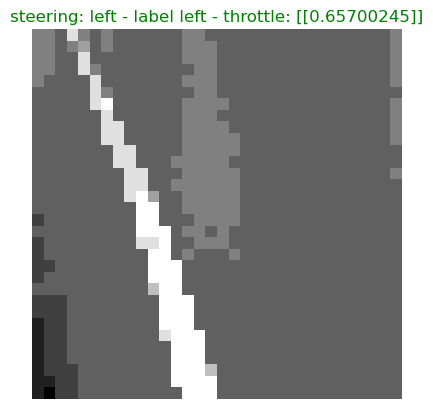

steering:  [[0.9714738]]
runs/run02/00001_0.97_0.68.jpg


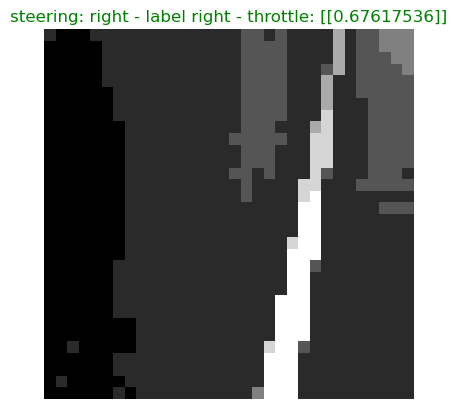

steering:  [[0.02264318]]
runs/run02/00002_0.02_0.99.jpg


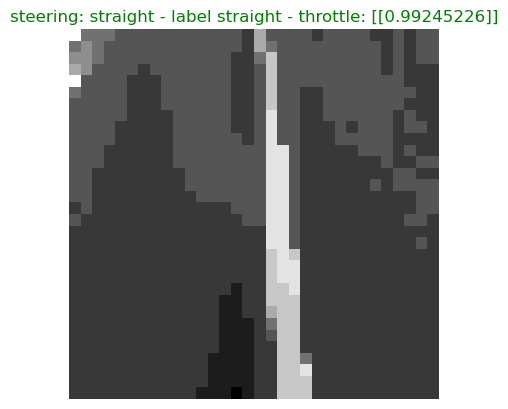

steering:  [[-1.0200002]]
runs/run02/00003_-1.02_0.66.jpg


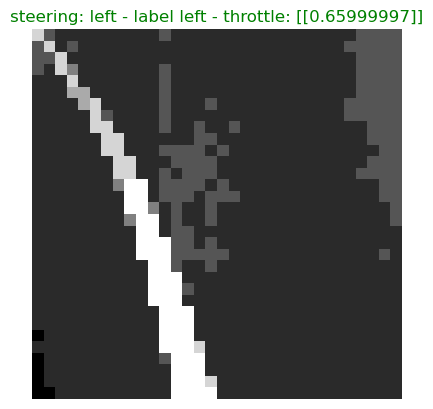

steering:  [[0.98049384]]
runs/run02/00004_0.98_0.67.jpg


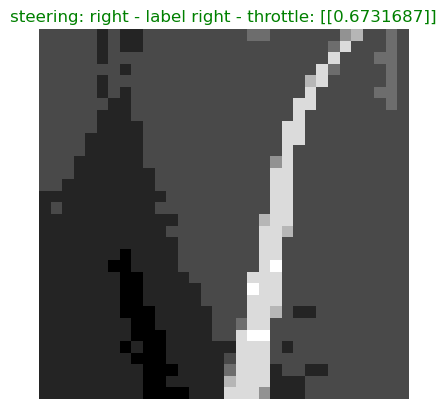

steering:  [[-0.9698776]]
runs/run02/00005_-0.97_0.68.jpg


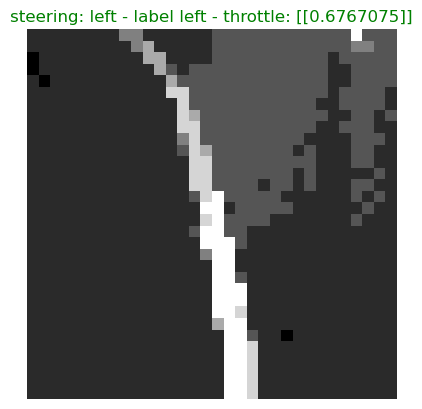

steering:  [[-1.0647907]]
runs/run02/00006_-1.06_0.65.jpg


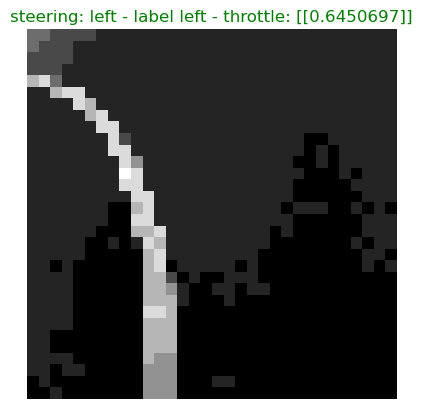

steering:  [[0.97809064]]
runs/run02/00007_0.98_0.67.jpg


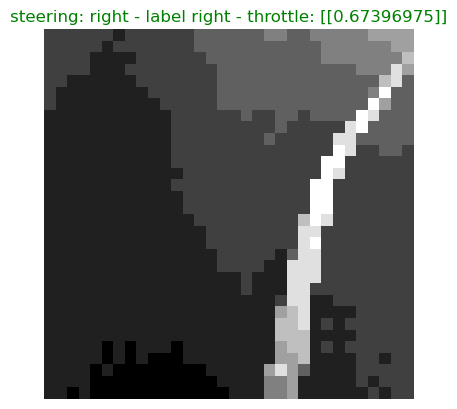

steering:  [[-0.97634995]]
runs/run02/00008_-0.98_0.67.jpg


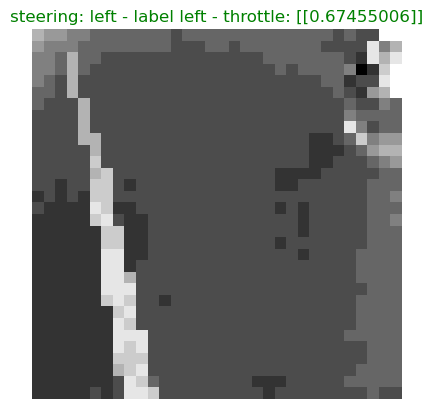

steering:  [[-1.0155492]]
runs/run02/00009_-1.02_0.66.jpg


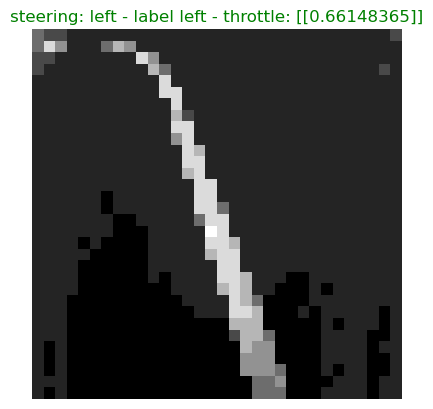

IndexError: list index out of range

In [20]:
speed = 0.5
binary_steering = True

correct = True

# create a new folder with the name run01, war the number increments if the filder alredy exists
run = 0
while True:
    run_dir = 'runs/run%02d' % run
    if not os.path.exists(run_dir):
        os.makedirs(run_dir)
        break
    run += 1

try:
    n = 0
    # main loop
    while correct:
        image, label = takeimage()
        procesedimage = preprocess(image)
        # add a batch dimension
        procesedimage = np.expand_dims(procesedimage, axis=0)
        # set the input tensor
        interpreter.set_tensor(input_details[0]['index'], procesedimage)
        # run the inference
        interpreter.invoke()
        # get the output tensor
        steering = interpreter.get_tensor(output_details[0]['index'])
        # we plot the image and the result
        print("steering: ", steering)

        # if steering is negative
        if steering < 0:
            throttle = (steering / 3) + 1
        else:
            throttle = ((- steering) / 3) + 1

        # save the image with a counter and the steering angle as a filename
        run_dir = 'runs/run%02d' % run
        filename = run_dir + '/%05d_%0.2f_%0.2f.jpg' % (n, steering, throttle)
        print(filename)
        cv2.imwrite(filename, image)
        n += 1

        if binary_steering:
            if steering < -0.5:
                steering = -1
                steering_label = "left"
            elif steering > 0.5:
                steering = 1
                steering_label = "right"
            else:
                steering = 0
                steering_label = "straight"

        # plot the image and the result and the label
        plt.imshow(procesedimage[0], cmap='gray')
        # tern off the axis
        plt.axis('off')
        if (steering_label == label):
            plt.title("steering: " + steering_label + " - label " + label + " - throttle: " + str(throttle), color='green')
        else:
            plt.title("steering: " + steering_label + " - label " + label + " - throttle: " + str(throttle), color='red')
            correct = False
        plt.show()
        
        # break        
        
        

except:
    # car.throttle = 0.0
    raise

## E stop

In [ ]:
car.throttle = 0.0